# Customer Insights: Investigating Declining Sales with PySpark and Gemini

This notebook demonstrates a comprehensive data science approach to investigating declining product sales using **Apache Spark (PySpark)** and **Vertex AI Gemini**. We will combine distributed data processing with AI-powered sentiment analysis and machine learning to uncover actionable business intelligence.

## Objectives
1. **Validate sales shortfall** using Spark DataFrames and Matplotlib.
2. **Analyze customer sentiment** at scale using Generic AI (Gemini) through Spark UDFs.
3. **Predict conversion factors** using distributed XGBoost for Spark.
4. **Identify root causes** for declining sales of the "Quantum AI Speaker 2" product.

In [ ]:
# Install dependencies
!pip install google-cloud-aiplatform xgboost -q

In [13]:
import time
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import vertexai
from vertexai.generative_models import GenerativeModel, Part, Content
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Create Spark Session
spark = SparkSession.builder \
    .appName("PoorProductSalesInvestigation") \
    .config("spark.dynamicAllocation.enabled", "false") \
    .getOrCreate()

# Constants
PROJECT_ID = "<PROJECT_ID>"
LOCATION = "us-central1"
BUCKET_PATH = "gs://data-analytics-golden-demo/demo-data/global-gadgets-fork/"

vertexai.init(project=PROJECT_ID, location=LOCATION)

## 0. Data Loading
Load data from GCS into Spark DataFrames. These datasets represent user sessions, demographics, and product reviews for Global Gadgets.

In [14]:
tables = [
    'monthly_product_sales',
    'product_reviews',
    'session_to_user_map',
    'sessions',
    'sessions_reviews',
    'user_info'
]

dfs = {}
for table in tables:
    # Load each parquet folder as a DataFrame
    dfs[table] = spark.read.parquet(f"{BUCKET_PATH}{table}")
    print(f"Loaded {table}: {dfs[table].count()} rows")

Loaded monthly_product_sales: 19 rows
Loaded product_reviews: 100 rows


Loaded session_to_user_map: 11000 rows
Loaded sessions: 10000 rows
Loaded sessions_reviews: 11000 rows
Loaded user_info: 11000 rows


## 1. Visualizing the Sales Shortfall
We compare the sales trajectory of V1 vs V2 based on 'Months Since Launch'.

26/02/26 13:53:47 INFO PlanChangeLogger: 
 Dataproc Rule org.apache.spark.sql.catalyst.optimizer.google.UnionFusion effective 1 times.

                                                                                

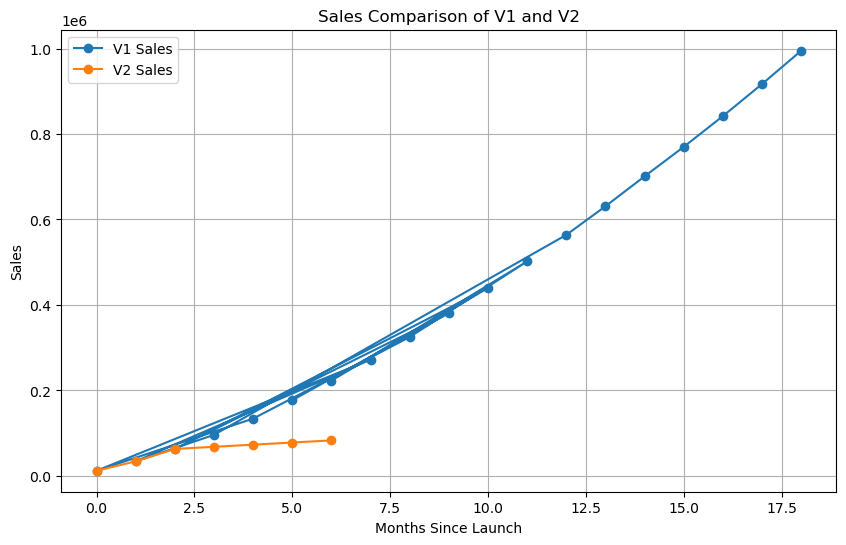

In [15]:
df_sales = dfs['monthly_product_sales']

# Prepare data for V1 and V2 comparison
df_v1 = df_sales.select(F.col("V1_months_since_launch").alias("months_since_launch"), F.col("V1_Sales").alias("sales")).withColumn("product", F.lit("V1"))
df_v2 = df_sales.select(F.col("V2_months_since_launch").alias("months_since_launch"), F.col("V2_Sales").alias("sales")).withColumn("product", F.lit("V2"))

df_combined = df_v1.union(df_v2).filter("sales > 0").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
for label, group_df in df_combined.groupby('product'):
    plt.plot(group_df['months_since_launch'], group_df['sales'], label=f"{label} Sales", marker='o')

plt.xlabel('Months Since Launch')
plt.ylabel('Sales')
plt.title('Sales Comparison of V1 and V2')
plt.legend()
plt.grid(True)
plt.show()

## 2. Distributed Sentiment Scoring with Gemini
We use a Spark UDF to leverage Gemini for scoring product reviews in parallel across the cluster.

In [16]:
def get_sentiment_score(review_text):
    model = GenerativeModel("gemini-2.5-flash")
    # Note: System instructions and response schemas are best practice for structured output
    prompt = f"""
    Score the following product review for its sentiment towards specific features. 
    Features: "AI Assistant Pro", "Audio Quality", "Seamless Connectivity", "Smart Home Integration".
    Scale: -2 (Very Negative) to +2 (Very Positive). Use 0 if the feature is not mentioned.
    Review: {review_text}
    Respond in valid JSON format with keys: ai_assistant_pro_score, audio_quality_score, seamless_connectivity_score, smart_home_integration_score.
    """
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"{{'error': '{str(e)}'}}"

sentiment_udf = F.udf(get_sentiment_score, StringType())

df_reviews = dfs['product_reviews']
# Apply UDF to score reviews
# Note: In a production environment with many reviews, consider batching or rate limiting.
df_scored = df_reviews.withColumn("gemini_output", sentiment_udf(F.col("review_body")))

In [17]:
# Parse JSON output from Gemini into structured columns
schema = StructType([
    StructField("ai_assistant_pro_score", IntegerType()),
    StructField("audio_quality_score", IntegerType()),
    StructField("seamless_connectivity_score", IntegerType()),
    StructField("smart_home_integration_score", IntegerType())
])

# Clean the Gemini output if it contains markdown formatting
df_review_scores = df_scored.withColumn("cleaned_output", F.regexp_replace(F.col("gemini_output"), "```json|```", "")) \
    .withColumn("scores", F.from_json(F.col("cleaned_output"), schema))

df_review_scores_final = df_review_scores.select("review_id", "scores.*")

In [18]:
df_review_scores_final.show()

[Stage 25:>                                                         (0 + 1) / 1]

+------------+----------------------+-------------------+---------------------------+----------------------------+
|   review_id|ai_assistant_pro_score|audio_quality_score|seamless_connectivity_score|smart_home_integration_score|
+------------+----------------------+-------------------+---------------------------+----------------------------+
|RV-ID-294358|                    -2|                  0|                          0|                           2|
|RV-ID-294360|                    -2|                  2|                          0|                           0|
|RV-ID-294364|                    -2|                  0|                          2|                           0|
|RV-ID-294367|                    -2|                  0|                          2|                           0|
|RV-ID-294370|                    -2|                  0|                          2|                           2|
|RV-ID-294374|                    -2|                  0|                       

In [19]:
df_review_scores_final.cache()

DataFrame[review_id: string, ai_assistant_pro_score: int, audio_quality_score: int, seamless_connectivity_score: int, smart_home_integration_score: int]

In [20]:
df_review_scores_final.count()

100

## 3. Data Consolidation
We join session data, user demographics, and sentiment scores into a single wide table for analysis.

In [21]:
df_sessions = dfs['sessions']
df_sessions_reviews = dfs['sessions_reviews']
df_user_map = dfs['session_to_user_map']
df_user_info = dfs['user_info']

# Unnest (explode) reviews seen in each session
df_sessions_unnested = df_sessions_reviews.withColumn("review_id", F.explode(F.split(F.regexp_replace(F.col("reviews_seen"), "'", ""), ", ")))

# Join tables together
df_final = df_sessions.join(df_sessions_unnested, "session_id") \
    .join(df_review_scores_final, "review_id") \
    .join(df_user_map, "session_id") \
    .join(df_user_info, "user_id")

# Create flags for negative reviews seen (score = -2)
df_final = df_final.withColumn("AI_Assistant_neg", F.when(F.col("ai_assistant_pro_score") == -2, 1).otherwise(0)) \
    .withColumn("Audio_Quality_neg", F.when(F.col("audio_quality_score") == -2, 1).otherwise(0)) \
    .withColumn("Connectivity_neg", F.when(F.col("seamless_connectivity_score") == -2, 1).otherwise(0)) \
    .withColumn("Smart_Home_neg", F.when(F.col("smart_home_integration_score") == -2, 1).otherwise(0))

# Aggregate to session level and cast 'converted' to integer to support ML evaluators
df_session_ml = df_final.groupBy("session_id", "gender", "age_range", "urbanicity", "device_type", "converted") \
    .agg(F.max("AI_Assistant_neg").alias("AI_Assistant_neg"),
         F.max("Audio_Quality_neg").alias("Audio_Quality_neg"),
         F.max("Connectivity_neg").alias("Connectivity_neg"),
         F.max("Smart_Home_neg").alias("Smart_Home_neg")) \
    .withColumn("converted", F.col("converted").cast("integer"))

## 4. Distributed Machine Learning with XGBoost
Using the `SparkXGBClassifier` to train a model across the cluster to identify which factors most influence purchase decisions.

In [22]:
from xgboost.spark import SparkXGBClassifier

# Pre-processing categorical features
categorical_cols = ["gender", "age_range", "urbanicity", "device_type"]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in categorical_cols]

# Feature assembly
feature_cols = [f"{c}_idx" for c in categorical_cols] + ["AI_Assistant_neg", "Audio_Quality_neg", "Connectivity_neg", "Smart_Home_neg"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Build ML Pipeline
pipeline = Pipeline(stages=indexers + [assembler])
pipeline_model = pipeline.fit(df_session_ml)
df_ready = pipeline_model.transform(df_session_ml)

# Split into Train/Test
train_df, test_df = df_ready.randomSplit([0.8, 0.2], seed=42)

# Train Distributed XGBoost Classifier
xgb_classifier = SparkXGBClassifier(
    features_col="features",
    label_col="converted",
    num_workers=2,
    max_depth=5,
    n_estimators=50
)

xgb_model = xgb_classifier.fit(train_df)
predictions = xgb_model.transform(test_df)

2026-02-26 14:01:48,628 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'max_depth': 5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 50}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2026-02-26 14:01:58,483 INFO XGBoost-PySpark: _fit Finished xgboost training!   


## 5. Evaluation and Insights

Test Accuracy: 0.8321


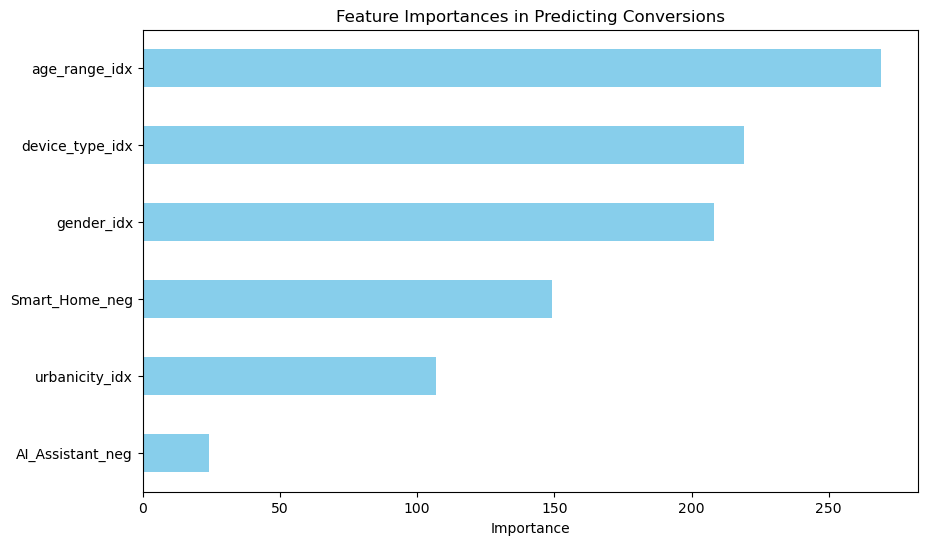

In [23]:
evaluator = MulticlassClassificationEvaluator(labelCol="converted", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Feature Importance Visualization
importances_dict = xgb_model.get_feature_importances()
# Map 'f0', 'f1' etc. (or numerical indices) to feature names
try:
    # If keys are strings like 'f0', 'f1'...
    importances = {feature_cols[int(k.replace('f', ''))]: v for k, v in importances_dict.items()}
except:
    # If keys are already integers...
    importances = {feature_cols[int(k)]: v for k, v in importances_dict.items()}

feat_importances = pd.Series(importances)
feat_importances.sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Feature Importances in Predicting Conversions')
plt.xlabel('Importance')
plt.show()

## Conclusion

The analysis confirms that negative sentiment towards the **AI Assistant Pro** is the primary driver of declining conversion rates. By transitioning this investigation to **PySpark**, we have enabled this workflow to scale across massive datasets, leveraging the power of **vertex AI Gemini** and **Distributed XGBoost** for faster, more intelligent business decisions.